In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.model_selection import train_test_split

import keras
from keras.utils import np_utils
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.optimizers import  Adam
from keras import regularizers
from keras import backend as K

import IPython.core.display as di
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)
pd.options.mode.chained_assignment = None

Using TensorFlow backend.


In [2]:
def imp(path):
    df = pd.read_csv(path)
    del df["Unnamed: 0"]
    print(df.shape)
    df1 = df.iloc[:,:4]
    df2 = df1.sort(["StartTime"], ascending = True)
    df3 = df2.reset_index(drop = True)
    count_s = count(df3, "SrcAddr")
    count_d = count(df3, "DstAddr")
    print("=====SrcAddr=====")
    print(count_s.head(10))
    print("=====DstAddr=====")
    print(count_d.head(10))
    return df3

In [3]:
def count(df, feature):
    a = pd.DataFrame(df[feature].value_counts())
    a.columns = ["degree"]
    a["IP"] = a.index
    a = a.reset_index(drop = True)
    return a

In [4]:
df_time = imp("st_ctu13.csv")

(2619340, 31)


/Users/Shawn/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:6: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


=====SrcAddr=====
   degree             IP
0  529886  147.32.84.138
1  239857   147.32.84.59
2  113053  147.32.84.229
3   44863   147.32.85.25
4   44556    70.37.98.60
5   35157   147.32.85.34
6   30584   147.32.86.20
7   28126  147.32.84.165
8   18435  147.32.84.170
9   14350  147.32.84.171
=====DstAddr=====
    degree              IP
0  1053030   147.32.84.229
1   960854     147.32.80.9
2    45049   147.32.85.100
3    19518    147.32.80.13
4     9067     147.32.1.20
5     7202    147.32.84.59
6     7035  188.138.84.239
7     5991     147.32.84.2
8     4567   87.98.230.229
9     3193     77.78.99.21


Shape of one time_window: (500, 4)
   StartTime          SrcAddr        DstAddr  label
0          0    212.50.71.179  147.32.84.229      0
1          1    84.13.246.132  147.32.84.229      0
2          2    217.163.21.35  147.32.86.194      0
3          3       83.3.77.74    147.32.85.5      0
4          4    74.89.223.204  147.32.84.229      0
5          5   66.169.184.207  147.32.84.229      0
6          6  182.239.167.121  147.32.84.229      0
7          7      147.32.3.93   147.32.84.59      0
8          8    24.117.206.20  147.32.84.229      0
9          9     94.208.78.74  147.32.84.229      0


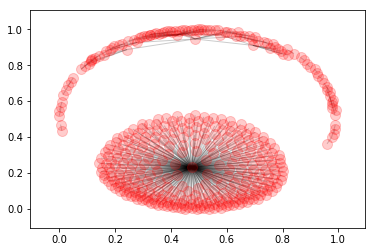

In [5]:
i = 0
time_window = 500
df1 = df_time[((i)*time_window <= df_time.StartTime) & (df_time.StartTime < (i+1)*time_window)]
print('Shape of one time_window:', df1.shape)
print(df1.head(10))

G = nx.from_pandas_dataframe(df1, 'SrcAddr', 'DstAddr', edge_attr = True)
nx.shortest_path(G)
nx.draw_networkx(G, node_size = 100, alpha = 0.2, with_labels = False)
plt.show()

> Sort by StartTime不依照IP排序，直接訓練。

In [6]:
### Count degree and rank
deg = pd.DataFrame(G.degree_iter())
deg.columns = ["SrcAddr", "degree"]
deg["DstAddr"] = deg.SrcAddr
print('Size of IP in one time_window:', deg.shape[0])
print(deg["degree"].value_counts())
deg["rank"] = deg.degree.rank(axis=0, method = 'average', numeric_only = None, na_option = 'keep', ascending = False, pct = False)
deg.head()

Size of IP in one time_window: 404
1      379
2       12
3        5
4        4
294      1
21       1
10       1
7        1
Name: degree, dtype: int64


,SrcAddr,degree,DstAddr,rank
0,212.50.71.179,1,212.50.71.179,215.0
1,147.32.84.229,294,147.32.84.229,1.0
2,84.13.246.132,1,84.13.246.132,215.0
3,217.163.21.35,1,217.163.21.35,215.0
4,147.32.86.194,4,147.32.86.194,6.5


In [7]:
def IP2deg(df, deg):
    df1 = df.merge(deg.iloc[:,[0,3]], how = 'inner', on = "SrcAddr")
    df2 = df1.merge(deg.iloc[:,[2,3]], how = 'inner', on = "DstAddr")
    return df2

In [8]:
df_deg = IP2deg(df1, deg)
df_deg.columns = ["StartTime","SrcAddr1","DstAddr1","label","SrcAddr","DstAddr"]
df_deg = df_deg.sort(["StartTime"], ascending = True)
df_deg = df_deg.reset_index(drop = True)
df_deg.head()

/Users/Shawn/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


,StartTime,SrcAddr1,DstAddr1,label,SrcAddr,DstAddr
0,0,212.50.71.179,147.32.84.229,0,215.0,1.0
1,1,84.13.246.132,147.32.84.229,0,215.0,1.0
2,2,217.163.21.35,147.32.86.194,0,215.0,6.5
3,3,83.3.77.74,147.32.85.5,0,215.0,6.5
4,4,74.89.223.204,147.32.84.229,0,215.0,1.0


> Change to rank

### for loop

In [9]:
time_window = 500
size_of_window = int((df_time.shape[0]) / time_window)

y = []
for i in range(size_of_window):
    df2 = df_time[(i*time_window <= df_time.StartTime) & (df_time.StartTime < (i+1)*time_window)]
    G = nx.from_pandas_dataframe(df2, 'SrcAddr', 'DstAddr', edge_attr = True)
    ###count degree and rank
    deg = pd.DataFrame(G.degree_iter())
    deg.columns = ["SrcAddr", "degree"]
    deg["DstAddr"] = deg.SrcAddr
    deg["rank"] = deg.degree.rank(axis=0, method = 'average', numeric_only = None, na_option = 'keep', ascending = False, pct = False)
    df_deg = IP2deg(df2, deg)
    df_deg.columns = ["StartTime","SrcAddr1","DstAddr1","label","SrcAddr","DstAddr"]
    y.append(df_deg)

appended_data = pd.concat(y, axis = 0)
print(appended_data.shape, df_time.shape)
appended_data.head()

(2619000, 6) (2619340, 4)


,StartTime,SrcAddr1,DstAddr1,label,SrcAddr,DstAddr
0,0,212.50.71.179,147.32.84.229,0,215.0,1.0
1,1,84.13.246.132,147.32.84.229,0,215.0,1.0
2,4,74.89.223.204,147.32.84.229,0,215.0,1.0
3,5,66.169.184.207,147.32.84.229,0,215.0,1.0
4,6,182.239.167.121,147.32.84.229,0,215.0,1.0


In [15]:
### Training and Testing
training_size = int(size_of_window * 0.8) * time_window
data = appended_data.iloc[:training_size,:]
test = appended_data.iloc[training_size:,:]

def reshape(df):
    x = np.array(df[["SrcAddr", "DstAddr"]])
    y = np.array(df[["label"]])
    seq_length = 1
    X = np.reshape(x, (len(x), seq_length, 2))
    X = X / np.max(df.SrcAddr)
    Y = np_utils.to_categorical(y)
    print(X.shape, Y.shape)
    return X, Y

In [16]:
X_train, y_train = reshape(data)
X_test, y_test = reshape(test)

a = pd.DataFrame(y_test, columns=["N", "B"])
b = pd.DataFrame(a["B"].value_counts())
base = a[a.B == 1].shape[0] / a.shape[0]
class_weight = b.iloc[0, 0] / b.iloc[1, 0]

print("Base line:", (1-base))
print("class weight:", class_weight)

(2095000, 1, 2) (2095000, 2)
(524000, 1, 2) (524000, 2)
Base line: 0.9860667938931298
class weight: 70.7709902753


In [17]:
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(16, return_sequences = False,
               input_shape = (X_train.shape[1], X_train.shape[2])))
#model.add(LSTM(512, return_sequences = True))
#model.add(LSTM(512, return_sequences = True))
#model.add(LSTM(512, return_sequences = True))
#model.add(LSTM(512))
model.add(Dense(y_train.shape[1], activation='softmax'))
model.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 16)                1216      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 34        
Total params: 1,250
Trainable params: 1,250
Non-trainable params: 0
_________________________________________________________________


Train on 1885500 samples, validate on 209500 samples
Epoch 1/2
1885500/1885500 [==============================] - 16s - loss: 0.8649 - acc: 0.8498 - val_loss: 0.4634 - val_acc: 0.8182

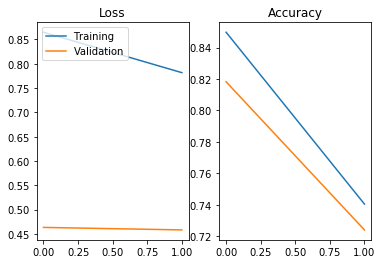

In [18]:
batch_size = int(X_train.shape[0]*0.001)
nb_epoch = 2

history = model.fit(X_train, y_train,
                    batch_size = batch_size,  
                    epochs = nb_epoch,  
                    verbose = 1,  
                    validation_split = 0.1,  
                    class_weight = {0: 1, 1: class_weight})

loss = history.history.get('loss')
acc = history.history.get('acc')

''' Access the performance on validation data '''
val_loss = history.history.get('val_loss')
val_acc = history.history.get('val_acc')

''' Visualize the loss and accuracy of both models'''
import matplotlib.pyplot as plt
plt.figure(0)
plt.subplot(121)
plt.plot(range(len(loss)), loss,label = 'Training')
plt.plot(range(len(val_loss)), val_loss,label = 'Validation')
plt.title('Loss')
plt.legend(loc='upper left')
plt.subplot(122)
plt.plot(range(len(acc)), acc,label = 'Training')
plt.plot(range(len(val_acc)), val_acc,label = 'Validation')
plt.title('Accuracy')
plt.show()

In [19]:
score = model.evaluate(X_test, y_test, verbose = 1)
print('Validation score:', score[0])
print('Validation accuracy:', score[1])

523360/524000 [============================>.] - ETA: 0s  

In [20]:
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion matrix',
                          cmap = plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment = "center",
                 color = "white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

522912/524000 [============================>.] - ETA: 0s  

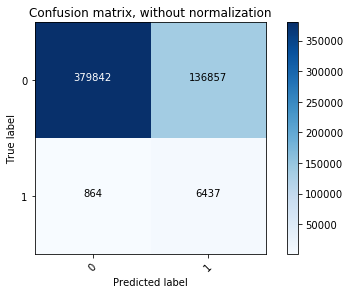

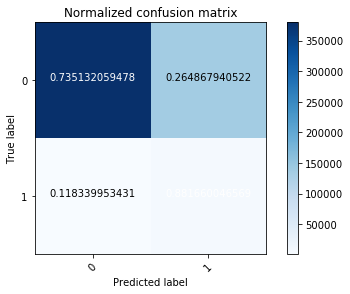

In [21]:
from sklearn.metrics import confusion_matrix
import itertools

y_true = y_test[:,1]
y_pred = model.predict_classes(X_test)
cm = confusion_matrix(y_true, y_pred, labels = None, sample_weight = None)

np.set_printoptions(precision=2)
class_names = ["0", "1"]

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes = class_names,
                      title = 'Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes = class_names, normalize = True,
                      title = 'Normalized confusion matrix')

plt.show()

## Testing

In [22]:
test_time = imp("testctu13.csv")

(1526570, 31)


/Users/Shawn/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:6: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


=====SrcAddr=====
   degree             IP
0  374978  147.32.84.138
1  152785   147.32.84.59
2   57911  147.32.84.229
3   34140   147.32.85.25
4   21755   147.32.85.34
5   20428   147.32.86.20
6   19662  147.32.86.165
7   11287  147.32.84.131
8    9428    147.32.85.7
9    9398  147.32.84.118
=====DstAddr=====
   degree              IP
0  661569     147.32.80.9
1  496714   147.32.84.229
2   24908   147.32.86.165
3   12934    147.32.80.13
4    5297     147.32.1.20
5    4708  188.138.84.239
6    3940     147.32.84.2
7    3890   147.32.84.118
8    3042   87.98.230.229
9    2704  147.32.127.222


In [23]:
time_window = 500
size_of_window = int((test_time.shape[0]) / time_window)

y = []
for i in range(size_of_window):
    df2 = test_time[(i*time_window <= test_time.StartTime) & (test_time.StartTime < (i+1)*time_window)]
    G = nx.from_pandas_dataframe(df2, 'SrcAddr', 'DstAddr', edge_attr = True)
    
    deg = pd.DataFrame(G.degree_iter())
    deg.columns = ["SrcAddr", "degree"]
    deg["DstAddr"] = deg.SrcAddr
    deg["rank"] = deg.degree.rank(axis=0, method = 'average', numeric_only = None, na_option = 'keep', ascending = False, pct = False)
    df_deg = IP2deg(df2, deg)
    df_deg.columns = ["StartTime","SrcAddr1","DstAddr1","label","SrcAddr","DstAddr"]
    y.append(df_deg)
    
test_appended = pd.concat(y, axis = 0)
print(test_appended.shape, test_time.shape)
test_appended.head()

(1518792, 6) (1526570, 4)


,StartTime,SrcAddr1,DstAddr1,label,SrcAddr,DstAddr
0,0,203.253.8.233,147.32.84.229,0,236.0,1.0
1,1,81.47.154.13,147.32.84.229,0,236.0,1.0
2,4,195.47.34.216,147.32.84.229,0,236.0,1.0
3,6,91.149.190.125,147.32.84.229,0,236.0,1.0
4,7,71.194.210.129,147.32.84.229,0,236.0,1.0


In [26]:
test_Xt, test_yt = reshape(test_appended)
print(test_appended["label"].value_counts())

(1518792, 1, 2) (1518792, 2)
0    1511059
1       7733
Name: label, dtype: int64


In [27]:
a = pd.DataFrame(test_yt, columns=["N", "B"])
b = pd.DataFrame(a["B"].value_counts())
base = a[a.B == 1].shape[0] / a.shape[0]
class_weight = b.iloc[0, 0] / b.iloc[1, 0]

print("Base line:", (1-base))
print("class weight:", class_weight)

Base line: 0.9949084535604612
class weight: 195.40398293


In [ ]:
score = model.evaluate(test_Xt, test_yt, verbose = 0)
print("===")
print('Test score:', score[0])  
print('Test accuracy:', score[1])

In [ ]:
y_true = test_yt[:,1]
y_pred = model.predict_classes(test_Xt)

In [ ]:
cm = confusion_matrix(y_true, y_pred, labels = None, sample_weight = None)

np.set_printoptions(precision=2)
class_names = ["0", "1"]

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes = class_names,
                      title = 'Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes = class_names, normalize = True,
                      title = 'Normalized confusion matrix')

plt.show()